<a href="https://colab.research.google.com/github/isabellasoldner/isabellasoldner.github.io/blob/master/Upload_numpy_images_batchy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install earthengine-api


     |████████████████████████████████| 153kB 9.4MB/s 
  Created wheel for earthengine-api: filename=earthengine_api-0.1.203-cp36-none-any.whl size=174918 sha256=2c37f5c9f08c8fc1dcc23ecde0f7bc343854c5339c770f5658fc1dd5ba8d22ab
  Stored in directory: /root/.cache/pip/wheels/26/69/ab/4ca47642ccc729cdc6e39b57b9e83164cddefc23b576aadac0
Successfully built earthengine-api


In [3]:
!earthengine authenticate

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/sQEBe37BOIiIOQJda5EOW5j28tfzkyhs5nuMeFRkDND

In [0]:
""" get ee image, define roi, save numpy array. 
    needed to save information from more than just RGB 
    (all that is available in jpg/png) from images and to
    use sentinel hub cloud detector """

import ee, os, io, urllib, logging
import pandas as pd
import numpy as np
import google.cloud.storage as gcs
from tensorflow.python.lib.io import file_io
from datetime import datetime
import IPython.display
from io import BytesIO
import matplotlib.pyplot as plt
from google.colab import drive
ee.Initialize()

In [5]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()


In [0]:
root_path = '/content/gdrive/My Drive/Colab Notebooks/Models'

os.environ['GOOGLE_APPLICATION_CREDENTIALS']= "/content/gdrive/My Drive/Colab Notebooks/emissions-monitoring-user.json"

# set client library, must do this every time 
client = gcs.Client()

In [0]:
project_id = 'emissions-monitoring'
bucket = 'satellite-data'

import uuid
bucket_name = bucket + str(uuid.uuid1())

In [10]:
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [0]:
!mkdir -p /tmp/satellite-data/upload_numpy/


In [0]:
from geopy.distance import great_circle
from geopy.distance import vincenty
from geopy import Point
from geopy.distance import vincenty
def get_roi_by_dist(lat1,lon1,distKm):
    ## This uses a km distance to find the longitudes and latitudes of a box around 
    # a longitude and latitude point
    N=vincenty(kilometers=distKm).destination(Point(lat1, lon1), 0).format_decimal()
    E=vincenty(kilometers=distKm).destination(Point(lat1, lon1), 90).format_decimal()
    S=vincenty(kilometers=distKm).destination(Point(lat1, lon1), 180).format_decimal()
    W=vincenty(kilometers=distKm).destination(Point(lat1, lon1), 270).format_decimal() 
    W=np.fromstring(W, dtype=np.float, sep=',' )
    S=np.fromstring(S, dtype=np.float, sep=',' )
    N=np.fromstring(N, dtype=np.float, sep=',' )
    E=np.fromstring(E, dtype=np.float, sep=',' )
    roi_1 = [W[1], S[0], E[1], N[0]]
    #print(roi_1)
    roi_2=[W,S,E,N]
    #print(roi_2)
    return roi_1,roi_2

def get_coordinates(orispl, plant_df):
    plant_df = plant_df[plant_df['ORISPL'] == orispl]
    lat, lon = plant_df['LAT_GPPD'].iloc[0], plant_df['LON_GPPD'].iloc[0]
    if type(lat) != float:
        lat, lon = plant_df['LAT_eGRID'].iloc[0], plant_df['LON_eGRID'].iloc[0]
    return lat, lon

def get_image_id(im):
  return ee.Feature(None, {'id': im.id()})

  
def image_datetime(img):
  date_obj=ee.Date(img.get('system:time_start'))
  return date_obj.format('YYYY-MM-dd HH:MM:ss.SSS').getInfo()

##generation time is the one we use 
##https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

def image_gentime(img):
  date_obj=ee.Date(img.get('GENERATION_TIME'))
  return date_obj.format('YYYY-MM-dd HH:MM:ss.SSS').getInfo()

def img2timedf(im,orispl,image_id):
    tmp_dat=[image_gentime(im)]
    ee_datetime=pd.DataFrame(tmp_dat,columns=["DateTime"])
    ee_datetime['DateTime']=pd.to_datetime(ee_datetime['DateTime'])
    ee_datetime["Date"]=ee_datetime["DateTime"].dt.date
    ee_datetime["Hour"]=ee_datetime["DateTime"].dt.hour
    ee_datetime["ORISPL"]=orispl
    ee_datetime["image_id"]=image_id
    return ee_datetime

In [13]:
!gsutil cp 'gs://power-plant-data/US/subgroup-1/platts_subgroup1_US.csv' '/tmp/platts.csv'
platts =  pd.read_csv('/tmp/platts.csv') 
platts = pd.DataFrame({'LOCATIONID_Platts': [str(x) for x in list(set(platts['LOCATIONID']))]})

!gsutil cp 'gs://power-plant-data/US/Platts_GPPD_EPA_mapping.csv' '/tmp/EPA.csv'
plant_df =  pd.read_csv('/tmp/EPA.csv') 
plant_df['LOCATIONID_Platts'] = [str(x) for x in plant_df['LOCATIONID_Platts']]
plant_df = plant_df.merge(platts, how='right', on=['LOCATIONID_Platts'])

Copying gs://power-plant-data/US/subgroup-1/platts_subgroup1_US.csv...
/ [1 files][ 51.1 KiB/ 51.1 KiB]                                                
Operation completed over 1 objects/51.1 KiB.                                     
Copying gs://power-plant-data/US/Platts_GPPD_EPA_mapping.csv...
/ [1 files][333.4 KiB/333.4 KiB]                                                
Operation completed over 1 objects/333.4 KiB.                                    


In [0]:
orispls = [x for x in plant_df["ORISPL"].astype(int)]


In [0]:
def get_filtered_collection(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT):

    lat, lon = get_coordinates(orispl, plant_df)
    roi_1, roi_2 = get_roi_by_dist(lat, lon, DISTANCE_KM)

    bbox_rectangle = ee.Geometry.Rectangle(roi_1) # west, south, east, north

    image_collection=ee.ImageCollection(COLLECTION_NAME).filterBounds(bbox_rectangle).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUDY_PERCENT))
    return image_collection
  
def list_of_images(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT):
    image_collection=get_filtered_collection(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT)
    ids_of_images = image_collection.map(get_image_id).distinct('id').aggregate_array('id')
    ids_list = ids_of_images.getInfo()
    return ids_list
  
def get_reduced_image_around_power_plant(COLLECTION_NAME,img_id,CLIP_DIST,orispl,plant_df,SCALE_IN,MAXPIXELS_IN):
        # define the image
        error=0
        latlon=0
        img = ee.Image(COLLECTION_NAME+'/'+img_id)
         

        ##clip the image centered around power plant
        lat, lon = get_coordinates(orispl, plant_df)

        roi_1, roi_2 = get_roi_by_dist(lat, lon, CLIP_DIST)

        area= ee.Geometry.Rectangle(roi_1) # west, south, east, north

        img=img.clip(area)
        try:
            sample_check=img.geometry().bounds().getInfo()['coordinates']
            lon_2=np.mean([sample_check[0][0][0],sample_check[0][1][0],sample_check[0][2][0],sample_check[0][3][0]])
            lat_2=np.mean([sample_check[0][0][1],sample_check[0][1][1],sample_check[0][2][1],sample_check[0][3][1]])
        except:
            tmp_err["msg"]="plant super at the edge, so no image appears if you crop it too small"
            tmp_err["ORISPL"]=orispls[i]
            tmp_err["image_id"]=ids_list[j]
            df_err=pd.concat([df_err,tmp_err])
            print("plant super at the edge, so no image appears if you crop it too small")
            error=1
            lat_2=0
            lon_2=0
            latlon=0
        
       



        dist_image_center_to_power_plant = vincenty((lat, lon),(lat_2, lon_2)).km


        if dist_image_center_to_power_plant >= 0.1:
            tmp_err["msg"]="this doesn't work, too close to edge"
            tmp_err["ORISPL"]=orispls[i]
            tmp_err["image_id"]=ids_list[j]
            df_err=pd.concat([df_err,tmp_err])
            error=1
            latlon=0
        if (error == 0):
            area=img.geometry().bounds().getInfo()
            latlon = ee.Image.pixelLonLat().addBands(ee.Image(COLLECTION_NAME+'/'+img_id))
            try:
              latlon = latlon.reduceRegion(
              reducer=ee.Reducer.toList(),
              geometry=area,
              scale=SCALE_IN,
              maxPixels=MAXPIXELS_IN
            );
            except:
              latlon=0
              error=1
        return latlon
  

                                                   
def reducedimg2numpy_arr(reduced_arr,bands):
# get data into three different arrays
            error=0
            data = np.array((ee.Array(reduced_arr.get(bands)).getInfo()))
            lats = np.array((ee.Array(reduced_arr.get("latitude")).getInfo()))
            lons = np.array((ee.Array(reduced_arr.get("longitude")).getInfo()))
        
            if len(data) != len(lats):
                tmp_err["msg"]="data/lats mismatch, probably a weird hole in image"
                tmp_err["ORISPL"]=orispls[i]
                tmp_err["image_id"]=ids_list[j]
                df_err=pd.concat([df_err,tmp_err])
                print("data/lats mismatch, probably a weird hole in image")
                arr=0
                error=1
           

            if (error ==0):
              # get the unique coordinates
              uniqueLats = np.unique(lats)
              uniqueLons = np.unique(lons)

              # get number of columns and rows from coordinates
              ncols = len(uniqueLons)    
              nrows = len(uniqueLats)

              # determine pixelsizes
              ys = uniqueLats[1] - uniqueLats[0] 
              xs = uniqueLons[1] - uniqueLons[0]

              # create an array with dimensions of image
              arr = np.zeros([nrows, ncols], np.float32) #-9999

              # fill the array with values
              counter =0
              for y in range(0,len(arr),1):
                  for x in range(0,len(arr[0]),1):
                      if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                          counter+=1
                    
                          arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner)
            return arr

def imgid2time(COLLECTION_NAME,image_id,orispl):
    tmpdf=img2timedf(ee.Image(COLLECTION_NAME+'/'+image_id),orispl,image_id)
    return tmpdf        
  

In [0]:



def save_np_images(orispl):
  return write_numpy_arr2gcs(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT,CLIP_DIST,SCALE_IN,MAXPIXELS_IN,RGB_BANDS)

def write_numpy_arr2gcs(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT,CLIP_DIST,SCALE_IN,MAXPIXELS_IN,RGB_BANDS):
  id_list=list_of_images(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT)
  #####
  for ii in range(0,len(id_list)):
    im_id=id_list[ii]
    for jj in range(0,len(RGB_BANDS)):
      band=RGB_BANDS[jj]
      image_time, image_arr=get_numpy_img(img_id,COLLECTION_NAME,CLIP_DIST,orispl,plant_df,SCALE_IN,MAXPIXELS_IN,band)
      save_time2gcs(image_time,orispl)
      save_img2gcs(img_id,image_arr,band)
  return 
  
  
  
def save_time2gcs(image_time,orispl):
  filename="ORISPL"+str(orispl)+"image_time_rec.csv"
  image_time.to_csv('/tmp/satellite-data/upload_numpy/'+filename, mode='a', header=False)
  !gsutil cp '/tmp/satellite-data/upload_numpy/ORISPL*csv' 'gs://satellite-data/upload_numpy/'
  return
  
def save_img2gcs(img_id,image_arr,band):
    np.save(file_io.FileIO('/tmp/satellite-data/upload_numpy/'+img_id+"_ORISPL_"+str(orispl)+"_band_"+band+'.npy', 'w'), image_arr) 
    !gsutil cp '/tmp/satellite-data/upload_numpy/*ORISPL*npy' 'gs://satellite-data/upload_numpy/'
    !rm /tmp/satellite-data/upload_numpy/*ORISPL*npy
    return

def get_numpy_img(img_id,COLLECTION_NAME,CLIP_DIST,orispl,plant_df,SCALE_IN,MAXPIXELS_IN,band):
    im_time=imgid2time(COLLECTION_NAME,img_id,orispl)
    img_redu=get_reduced_image_around_power_plant(COLLECTION_NAME,img_id,CLIP_DIST,orispl,plant_df,SCALE_IN,MAXPIXELS_IN)
    im_arr=reducedimg2numpy_arr(img_redu,band)
    return im_time,im_arr


    

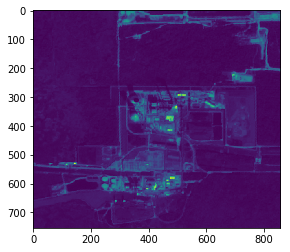

In [39]:
COLLECTION_NAME='COPERNICUS/S2_SR'
DISTANCE_KM=2.0
orispl=orispls[0]
CLOUDY_PERCENT=70
CLIP_DIST=1.5
SCALE_IN=4
MAXPIXELS_IN=20000000
RGB_BANDS=["B2","B3","B4"]


##check it works
id_list=list_of_images(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT)
img_id=id_list[0]

im_time=imgid2time(COLLECTION_NAME,img_id,orispl)
img_redu=get_reduced_image_around_power_plant(COLLECTION_NAME,img_id,CLIP_DIST,orispl,plant_df,SCALE_IN,MAXPIXELS_IN)
im_arr=reducedimg2numpy_arr(img_redu,RGB_BANDS[0])

plt.imshow(im_arr)
plt.show()
        

In [55]:
write_numpy_arr2gcs(COLLECTION_NAME,DISTANCE_KM,orispl,plant_df,CLOUDY_PERCENT,CLIP_DIST,SCALE_IN,MAXPIXELS_IN,RGB_BANDS)



Copying file:///tmp/satellite-data/upload_numpy/ORISPL628image_time_rec.csv [Content-Type=text/csv]...
/ [1 files][  158.0 B/  158.0 B]                                                
Operation completed over 1 objects/158.0 B.                                      
Copying file:///tmp/satellite-data/upload_numpy/20181218T161659_20181218T161750_T17RLN_ORISPL_628_band_B4.npy [Content-Type=application/octet-stream]...
Copying file:///tmp/satellite-data/upload_numpy/20181218T161659_20181218T161750_T17RLN_ORISPL_628_band_B3.npy [Content-Type=application/octet-stream]...
Copying file:///tmp/satellite-data/upload_numpy/20181218T161659_20181218T161750_T17RLN_ORISPL_628_band_B2.npy [Content-Type=application/octet-stream]...
|
Operation completed over 3 objects/7.4 MiB.                                      
Copying file:///tmp/satellite-data/upload_numpy/ORISPL628image_time_rec.csv [Content-Type=text/csv]...
/ [1 files][  237.0 B/  237.0 B]                                                
Operati

KeyboardInterrupt: ignored

In [95]:
orispls=orispls[0:2]
print(orispls)

[628]


In [0]:
from multiprocessing import Pool

with Pool(8) as pool:
  results = pool.map(save_np_images, orispls)
## per power plant perhaps



In [81]:
storage_client = storage.Client()
stats = storage.Blob(bucket=bucket, name='/upload_numpy/20181218T161659_20181218T161750_T17RLN_ORISPL_628_band_B2.npy').exists(storage_client)


 

DefaultCredentialsError: ignored